## Определение стоимости автомобиля
___

### Описание проекта

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.
Заказчику важны:
* качество предсказания;
* скорость предсказания;
* время обучения.
___

**Признаки:**  
* `DateCrawled` — дата скачивания анкеты из базы
* `VehicleType` — тип автомобильного кузова
* `RegistrationYear` — год регистрации автомобиля
* `Gearbox` — тип коробки передач
* `Power` — мощность (л. с.)
* `Model` — модель автомобиля
* `Kilometer` — пробег (км)
* `RegistrationMonth` — месяц регистрации автомобиля
* `FuelType` — тип топлива
* `Brand` — марка автомобиля
* `NotRepaired` — была машина в ремонте или нет
* `DateCreated` — дата создания анкеты
* `NumberOfPictures` — количество фотографий автомобиля
* `PostalCode` — почтовый индекс владельца анкеты (пользователя)
* `LastSeen` — дата последней активности пользователя  \

**Целевой признак:**
* `Price` — цена (евро)
___

### Структура проекта
<a href='#section1'></a>
1. [Подготовка данных](#section1)  
    1.1. [Импорт библиотек](#section1.1)  
    1.2. [Загрузка данных](#section1.2)   
    1.3. [Первичных осмотр](#section1.3)  
    1.4. [Выводы по главе 1](#section1.4)  
<a href='#section2'></a>  
2. [Анализ данных](#section2)  
    2.1. [Обработка дубликатов](#section2.1)  
    2.2. [Оценка важности признаков](#section2.2)  
    2.3. [Обработка пропусков](#section2.3)  
    2.4. [Работа с числовыми признаками](#section2.4)      
    2.5. [Работа с категориальными признаками](#section2.5)  
    2.6. [Выводы по главе 2](#section2.6)  
<a href='#section3'></a>  
3. [Построение модели](#section3)  
    3.1. [Подготовка данных к обучению](#section3.1)  
    3.2. [LinearRegression](#section3.2)  
    3.3. [RandomForestRegressor](#section3.3)  
    3.4. [LGBMRegressor](#section3.4)  
    3.5. [Выводы по главе 3](#section3.5)  
<a href='#section4'></a>  
4. [Выводы исследования](#section4)  
____
____

<a id='section1'></a>
## 1. Первичный осмотр данных

<a id='section1.1'></a>
### 1.1 Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
# Графика
import matplotlib.pyplot as plt
import seaborn as sns
# Модели
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
# Инструменты
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import make_scorer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from time import time
import os
# Sugar
from ipywidgets import IntProgress
from IPython.display import display
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_style('darkgrid')
sns.set_context("paper")

<a id='section1.2'></a>
### 1.2 Загрузка данных

In [2]:
def read_data(filename="autos.csv", foldername="datasets"):
    filepath = os.sep + foldername + os.sep + filename
    data = pd.read_csv(filepath)
    return data

In [3]:
data = read_data()
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<a id='section1.3'></a>
### 1.3 Первичный осмотр

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [5]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [6]:
data.shape

(354369, 16)

<a id='section1.4'></a>
### 1.4 Выводы по главе 1

1. Данные с пропусками;
2. Количественные и численные признаки присутствуют;
3. Есть лишние признаки относительно поставленной задачи:
    * `DateCrawled`;
    * `RegistrationMonth`;
    * `PostalCode`;
    * `LastSeen`
4. `NumberOfPictures` полностью состоит из нулей.
5. `Power`, `Price` содержат нули.

<a id='section2'></a>
## 2. Предобработка данных

<a id='section2.1'></a>
### 2.1 Обработка дубликатов

In [7]:
data[data.duplicated()]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


In [8]:
def no_duplicates(data): data.drop_duplicates(inplace=True)

In [9]:
no_duplicates(data)

In [10]:
data.shape

(354365, 16)

<a id='section2.2'></a>
### 2.2 Оценка важности признаков

In [11]:
def drop_useless_columns(data : pd.DataFrame, columns=["DateCrawled", "RegistrationMonth", "PostalCode", "LastSeen", "NumberOfPictures", "DateCreated"]):
    return data.drop(columns, axis=1)

In [12]:
# Удалим сначала бесполезные столбцы.
data = drop_useless_columns(data)

In [13]:
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


<a id='section2.3'></a>
### 2.3 Обработка пропусков

In [14]:
# Посмотрим на доли пропусков
def get_nans_pivot(data):
    return pd.DataFrame(
        data = {
            "NaNs number" : data.isna().sum(),
            "NaNs proportion" : (data.isna().sum() / data.shape[0]).round(4),
            "Column type" : data.dtypes
        }
    ).sort_values("NaNs proportion", ascending=False)

In [15]:
get_nans_pivot(data)

,NaNs number,NaNs proportion,Column type
NotRepaired,71154,0.2008,object
VehicleType,37490,0.1058,object
FuelType,32895,0.0928,object
Gearbox,19833,0.0560,object
Model,19705,0.0556,object
Price,0,0.0000,int64
RegistrationYear,0,0.0000,int64
Power,0,0.0000,int64
Kilometer,0,0.0000,int64
Brand,0,0.0000,object


Оказывается все пропуски сконцентрированы в категориальных признаках. Как же лень иногда заполнять анкету полностью😉
Спишем пропуски в отдельную категорию лени пользователей `unknown`. Всё-таки много пропусков, не хотелось бы перекоса от заполнения средним/медианой. 

In [16]:
def fill_nans_as_value(data : pd.DataFrame, value : str):
    nans_cols = data.isna().sum().index
    for col in nans_cols:
        data[col].fillna(value=value, inplace=True)

In [17]:
fill_nans_as_value(data, value="unknown")

In [18]:
# Check
get_nans_pivot(data)

,NaNs number,NaNs proportion,Column type
Price,0,0.0,int64
VehicleType,0,0.0,object
RegistrationYear,0,0.0,int64
Gearbox,0,0.0,object
Power,0,0.0,int64
Model,0,0.0,object
Kilometer,0,0.0,int64
FuelType,0,0.0,object
Brand,0,0.0,object
NotRepaired,0,0.0,object


<a id='section2.4'></a>
### 2.4 Работа с числовыми признаками

In [19]:
# Посмотрим на распределения для начала
def get_distribution(series : pd.Series):
    
    plt.figure(figsize=(16, 10))
    ax = sns.distplot(series, bins=100)
    ax.set_xlabel(series.name, fontsize=12)
    plt.title('Distribution of %s column'%series.name, fontsize=15)
    plt.figure(figsize=(10, 10))
    ax = sns.boxplot(y = series)
    ax.set_ylabel(series.name, fontsize=12)

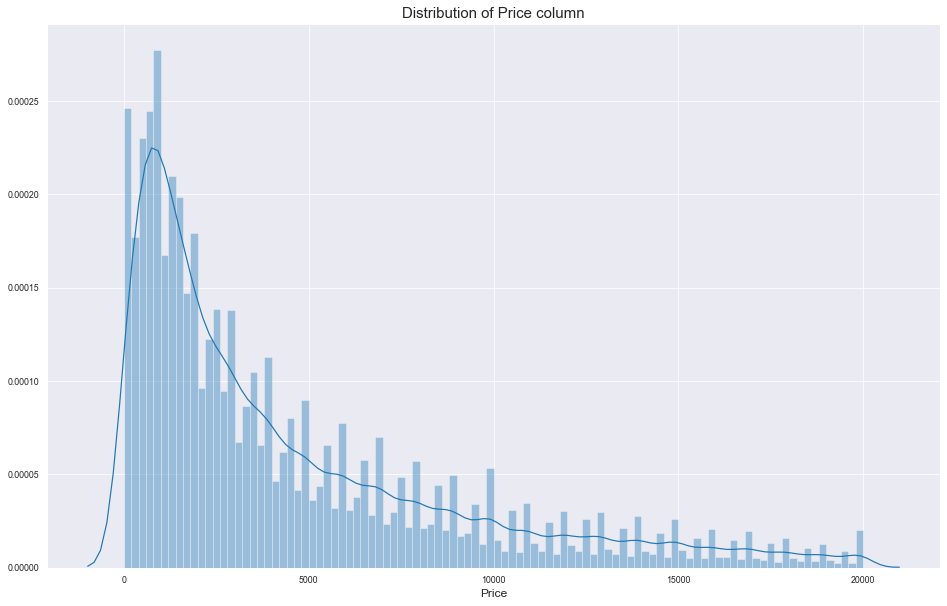

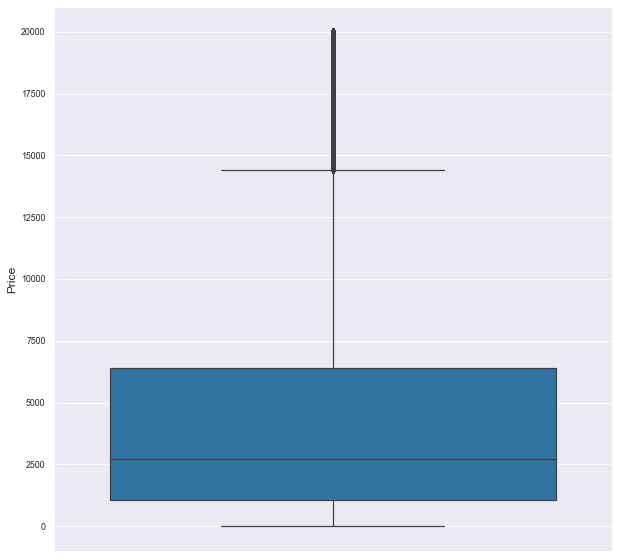

In [20]:
get_distribution(data.Price)

Посмотрим на отклонения выше 0.95-квантили и близкие к нулю.

In [21]:
def drop_column_tails(data : pd.DataFrame, column : str):
    q_05, q_95 = data[column].quantile(0.05), data[column].quantile(0.95)
    data = data[(data[column] >= q_05) & (data[column] <= q_95)]
    return data

In [22]:
data = drop_column_tails(data, "Price")

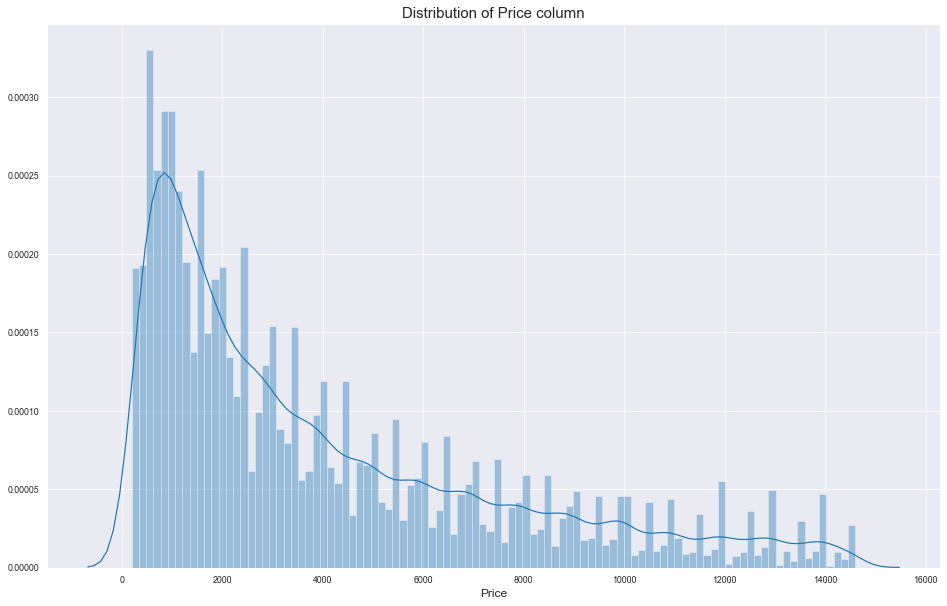

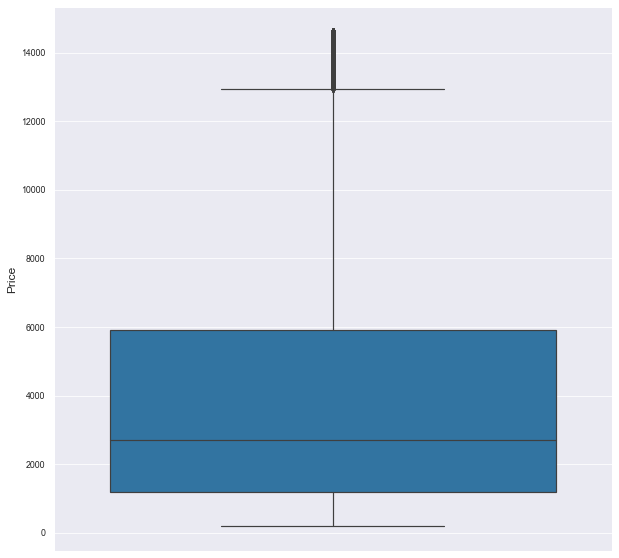

In [23]:
get_distribution(data.Price)

Так лучше. А то странная продажа авто по нулевой цене получалась)

In [24]:
data.shape

(319251, 10)

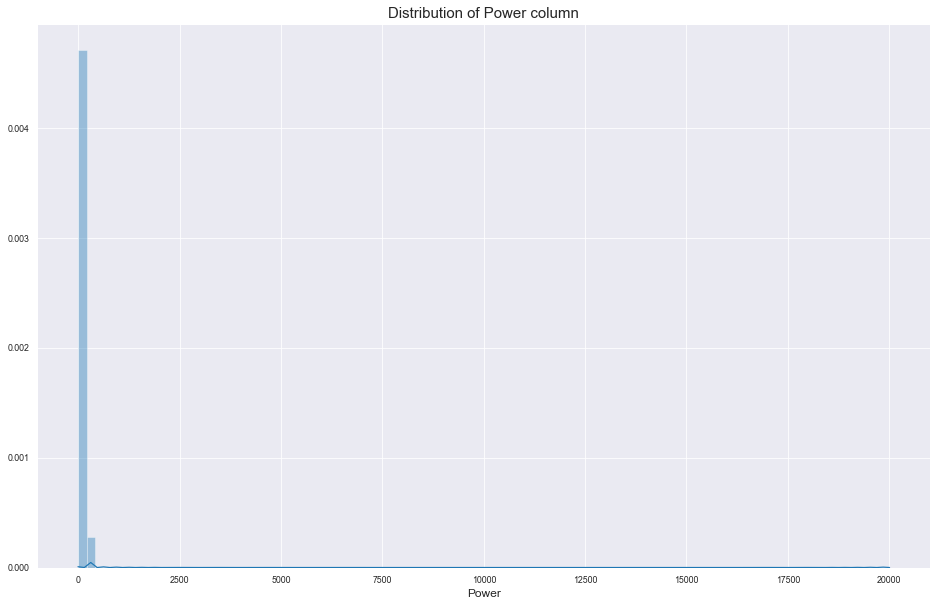

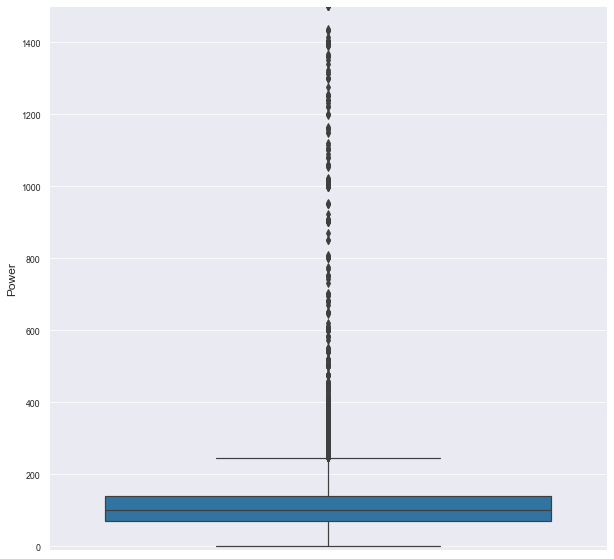

In [25]:
get_distribution(data.Power)
plt.ylim(-10, 1500);

Опять нули. Теперь только в лошадиных силах. 
Обработаем эти нули: замедим медианными значением в зависимости от марки, модели, типе топлива и пробеге.

In [26]:
def fill_column_nans_by_method(data : pd.DataFrame, 
                              column : str, 
                              features_columns=["Brand", "Model", "FuelType", "Kilometer"], 
                              method="median"):
    if column in features_columns:
        raise AtributeError("Column name in fillna features_columns. Please change the column or features_columns values.")
    method_column = data.groupby(features_columns)[column].transform(method)
    data[column] = (data[column]
              .replace(0, np.nan)
              .fillna(method_column)
    );

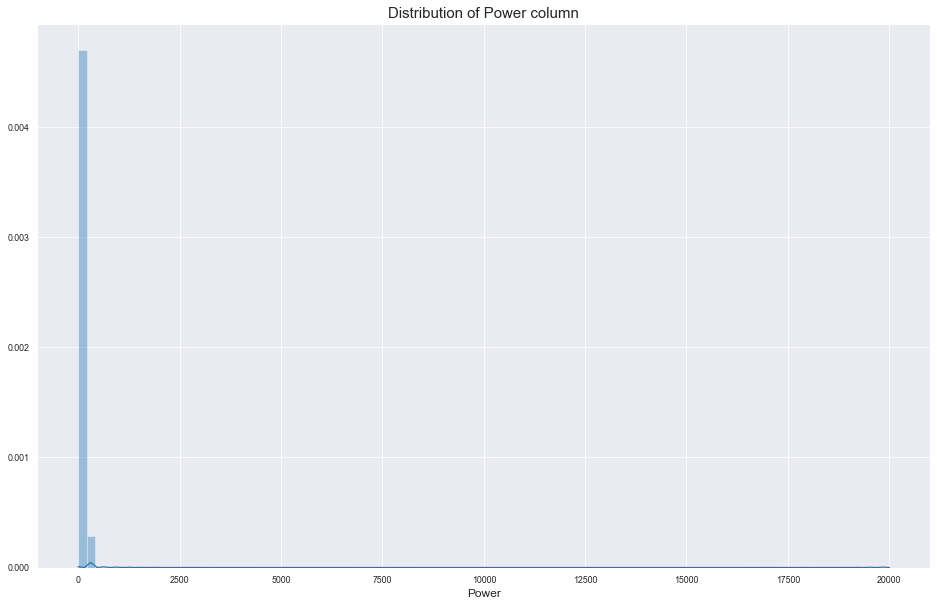

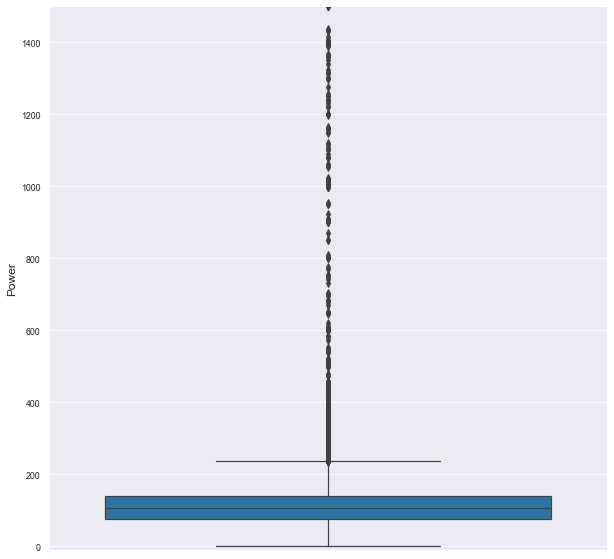

In [27]:
fill_column_nans_by_method(data, column="Power")
get_distribution(data.Power)
plt.ylim(-10, 1500);

In [28]:
data = data.query('Power < 1000')
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,unknown,1993,manual,75.0,golf,150000,petrol,volkswagen,unknown
2,9800,suv,2004,auto,163.0,grand,125000,gasoline,jeep,unknown
3,1500,small,2001,manual,75.0,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69.0,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102.0,3er,150000,petrol,bmw,yes


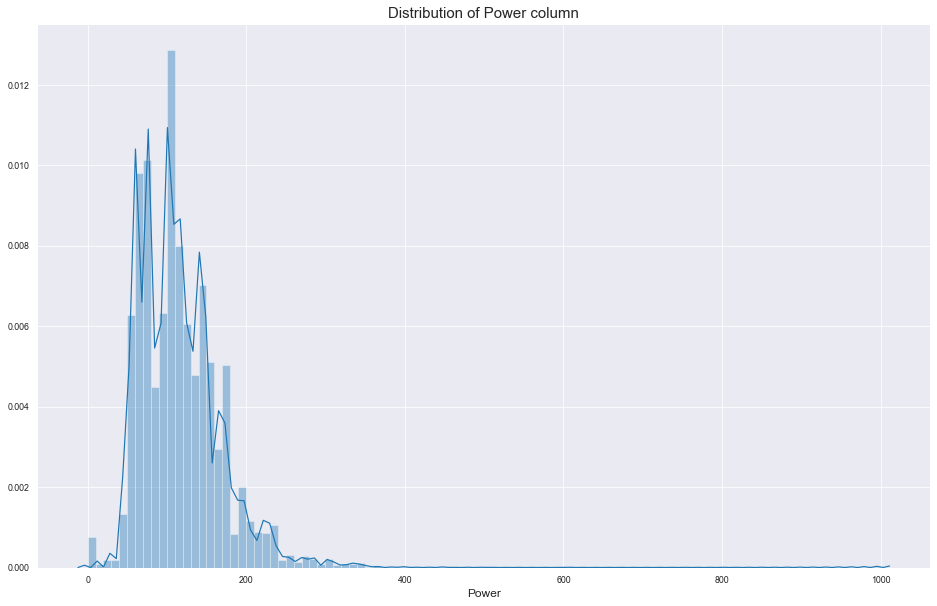

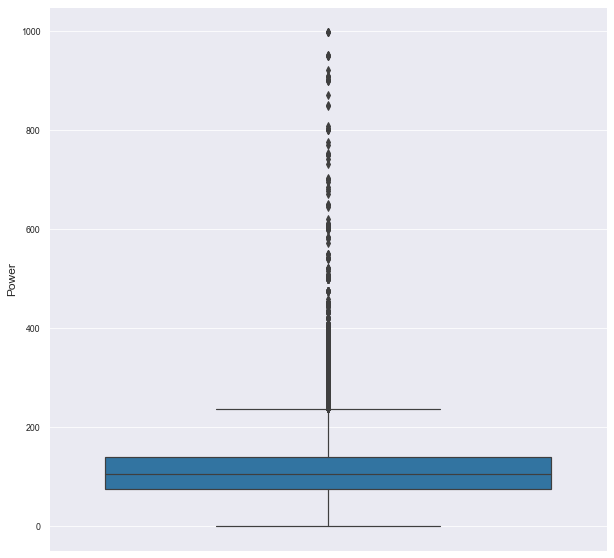

In [29]:
get_distribution(data.Power)

Остался пробег и можно будет заканчивать с предобработкой численных признаков😊

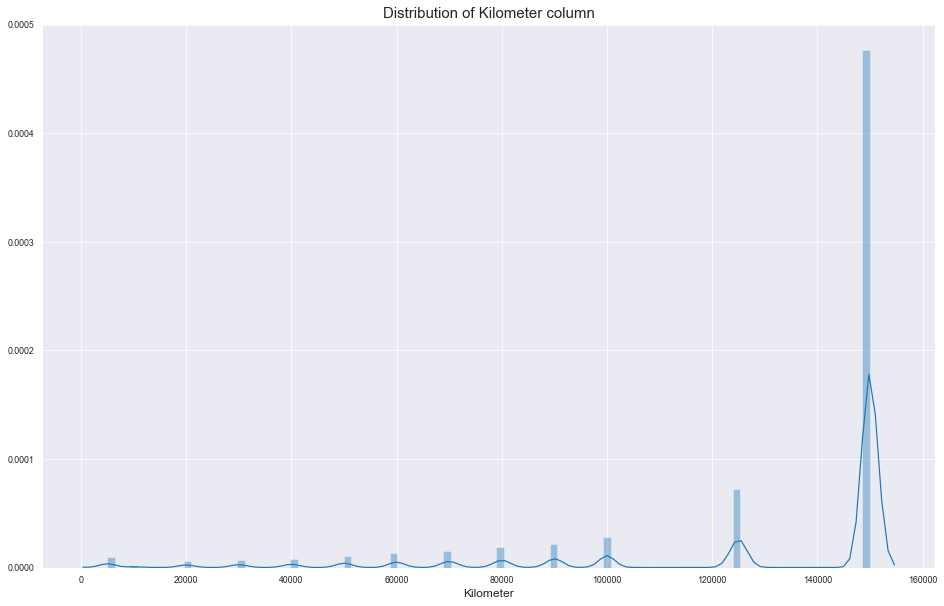

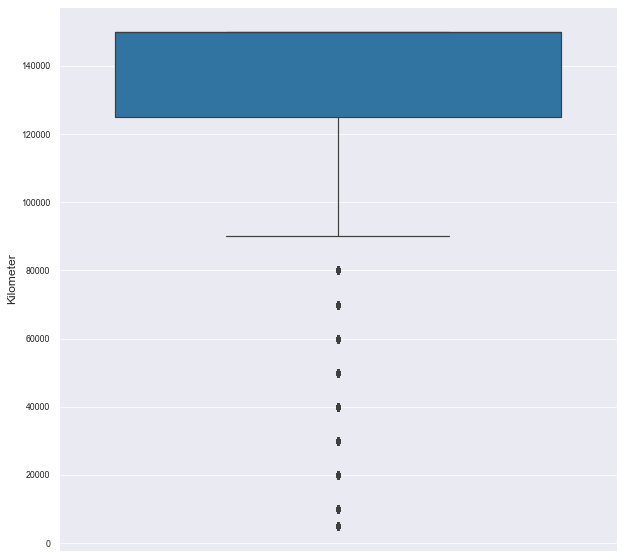

In [30]:
get_distribution(data.Kilometer)

А тут от нас ничего не требуется. Откровенной гадости нет. 
Видим, что, в основной массе, автомобили свыше 90.000 км стоят на продаже, а это сильно похоже на правду. 

<a id='section2.5'></a>
### 2.5 Работа с категориальными признаками

In [31]:
data.dtypes

Price                 int64
VehicleType          object
RegistrationYear      int64
Gearbox              object
Power               float64
Model                object
Kilometer             int64
FuelType             object
Brand                object
NotRepaired          object
dtype: object

Ну такое количество объектов в типах нашу модель не осчастливит. Поэтому план такой:
1. Напишем функцию по переводу в строковый формат;
2. Перекодируем в числовой.  
    Воспользуемся `Ohe` для первых двух моделей, а у последней имеется встроенный.
3. Масштабируем признаки.

<a id='section2.6'></a>
### 2.6 Выводы по главе 2

В ходе предобработки были произведены следующие действия над данными:
1. Обработаны дубликаты;
2. Удалены ненужные для задачи признаки;
3. Обработаны пропуски, как категориальные, так и числовые;
4. Категориальные признаки были перекодированы;
5. Произведено масштабирование признаков.

<a id='section3'></a>
## 3. Построение моделей

В качестве моделей были выбраны следующие представители:
* LinearRegression;
* RandomForestRegression;
* LGBMRegressor.

<a id='section3.1'></a>
### 3.1 Подготовка данных к обучению

In [32]:
def train_valid_test_split(data : pd.DataFrame, target_column : str, proportions=[0.6, 0.2, 0.2]):
    """
        Function splits by train, validation, test parts income dataframe.
        In:
            df : pandas.DataFrame() - income dataframe.
            proportions : list() - list of proportions values to split method.
    """
    if sum([*proportions]) != 1:
        raise AttributeError('Wrong "proportions" values. Sum of "proportions" values > 1.0. Must be equal to 1.0.')
    data_list = [train, valid, test] = np.split(
        data.sample(frac=1, random_state=2718), 
        [int(proportions[0] * len(data)), int(sum(proportions[:2]) * len(data))]
    )
    features, targets = list(), list()
    for data in data_list:
        features.append(data.drop(target_column, axis=1))
        targets.append(data[target_column])
    return [*features, *targets]

In [33]:
X = data.drop("Price", axis=1)
y = data.Price

In [34]:
# Train/test split.
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=2718)

In [35]:
all_data = pd.concat((X_train, X_test))
for column in all_data.select_dtypes(include=[object]).columns:
    print(column, all_data[column].unique())

VehicleType ['coupe' 'bus' 'wagon' 'small' 'convertible' 'sedan' 'unknown' 'suv'
 'other']
Gearbox ['auto' 'manual' 'unknown']
Model ['other' 'zafira' 'polo' 'a6' 'clio' 'astra' 'corsa' 'lancer' '2_reihe'
 '500' 'combo' 'e_klasse' 'unknown' 'modus' 'passat' 'octavia' 'c_max'
 'ka' 'golf' 'caddy' 'transporter' 'a4' 'c_klasse' 'c1' 'mx_reihe' 'focus'
 '3er' 'vectra' 'civic' '3_reihe' 'xc_reihe' 'arosa' 'c5' 'altea' 'lupo'
 'cooper' 'impreza' 'b_klasse' 'auris' 'vito' 'qashqai' 'fabia' 'almera'
 'kaefer' 'grand' 'kangoo' 'espace' 'm_klasse' 'touran' 'a3' 'ptcruiser'
 'i_reihe' 'punto' 'panda' 'antara' 's_klasse' 'mondeo' 'megane' 'z_reihe'
 'yaris' 'fiesta' '80' 'up' 'leon' 'a2' 'fortwo' 'bora' 'alhambra'
 '6_reihe' 'clk' 'a_klasse' 'twingo' 'ibiza' 'a5' 'galaxy' 'slk' '5er'
 'rio' 'seicento' '159' 'forfour' 'beetle' 'getz' 'primera' 'corolla' 'tt'
 'scenic' 'x_reihe' 'sharan' 'meriva' 'tucson' 'forester' 's_max' 'toledo'
 '100' 'matiz' 'v40' 'galant' 'clubman' '156' 'cc' 'scirocco' 'cuor

In [36]:
for column in all_data.select_dtypes(object).columns:
    unique_values = all_data[column].dropna().unique()
    X_train[column] = X_train[column].astype(pd.api.types.CategoricalDtype(categories=unique_values))
    X_test[column] = X_test[column].astype(pd.api.types.CategoricalDtype(categories=unique_values))

In [37]:
def print_table(table):
    longest_cols = [
        (max([len(str(row[i])) for row in table]) + 3)
        for i in range(len(table[0]))
    ]
    row_format = "".join(["{:>" + str(longest_col) + "}" for longest_col in longest_cols])
    for row in table:
        print(row_format.format(*row))

In [38]:
table = [
    ['Sample', 'Features_m', 'Features_n', 'Target'],
    ['Train', *X_train.shape, *y_train.shape],
    ['Test', *X_test.shape, *y_test.shape]
]

In [39]:
print_table(table)

   Sample   Features_m   Features_n   Target
    Train       255176            9   255176
     Test        63795            9    63795


In [40]:
def log_progress(sequence, every=10):
    progress = IntProgress(min=0, max=len(sequence), value=0)
    display(progress)
    
    for index, record in enumerate(sequence):
        if index % every == 0:
            progress.value = index
        yield record

In [41]:
def rmse(y_true, y_pred): return np.sqrt(mse(y_true, y_pred))

In [42]:
scorer = make_scorer(rmse, greater_is_better=False)

In [43]:
def cross_validation(model, X, y, param_grid, scoring):
    model_cv = GridSearchCV(
        model(),
        param_grid = param_grid,
        cv = 4,
        scoring = scoring,
        return_train_score=True
    )
    # Подбор гиперпараметров
    model_cv = model_cv.fit(X, y)
    # Best etimator
    model_best = model_cv.best_estimator_
    cv_results = model_cv.cv_results_

    # Train
    start_time = time()
    model_best.fit(X, y)
    train_time = time() - start_time
    # Predict
    start_time = time()
    predictions = model_best.predict(X)
    predict_time = time() - start_time
    # RMSE
    rmse_metrics = rmse(y, predictions)
    # Result list
    if type(model_best).__name__ == "LinearRegression":
        best_item = cv_results["rank_test_score"].item()
        rlt = [{
            "Model name" : type(model_best).__name__,
            "Train time" : round(train_time, 4),
            "Predict time" : round(predict_time, 4),
            "RMSE train_score" : -cv_results["split%s_test_score"%best_item].round(4).item(),
            "RMSE predict_score" : round(rmse_metrics, 4),
            "Parameters" : model_cv.best_params_
    }]
    else: 
        rlt = [{
            "Model name" : type(model_best).__name__,
            "Train time" : round(train_time, 4),
            "Predict time" : round(predict_time, 4),
            "RMSE train_score" : -model_cv.best_score_.round(4),
            "RMSE predict_score" : round(rmse_metrics, 4),
            "Parameters" : model_cv.best_params_
        }]
    return model_best, model_cv.best_params_, rlt

In [44]:
cat_cols = data.select_dtypes(object).columns
cat_cols

Index(['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired'], dtype='object')

In [45]:
results = []

Можно обучаться)  
Стартуем!😎

<a id='section3.2'></a>
### 3.2 LinearRegression

`OHE`

In [46]:
X_train_lr = pd.get_dummies(X_train, drop_first=True)
X_test_lr = pd.get_dummies(X_test, drop_first=True)
y_train_lr, y_test_lr = y_train, y_test
X_train_lr.shape, X_test_lr.shape

((255176, 311), (63795, 311))

Вот теперь одно количество признаков:)

`StandardScaler`

In [47]:
scaler = StandardScaler()
scaler.fit(X_train_lr)
X_train_lr = scaler.transform(X_train_lr)
X_test_lr = scaler.transform(X_test_lr)

In [48]:
%%time 

lr, lr_params, lr_result = cross_validation(
    model=LinearRegression,
    X = X_train_lr,
    y = y_train_lr,
    param_grid = {},
    scoring = scorer
)
results += lr_result
results[-1]

Wall time: 32.8 s


{'Model name': 'LinearRegression',
 'Train time': 5.1603,
 'Predict time': 0.1326,
 'RMSE train_score': 2360.6818,
 'RMSE predict_score': 2349.0026,
 'Parameters': {}}

<a id='section3.3'></a>
### 3.3 RandomForestRegression

In [49]:
X_train_rf, X_test_rf = X_train, X_test
y_train_rf, y_test_rf = y_train, y_test

`LabelEncoder`

In [50]:
oe = OrdinalEncoder()
oe.fit(X_train_rf[cat_cols])
X_train_rf[cat_cols] = oe.transform(X_train_rf[cat_cols])
X_test_rf[cat_cols] = oe.transform(X_test_rf[cat_cols])

X_train_rf.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
282114,2.0,1973,0.0,160.0,166.0,100000,6.0,10.0,0.0
96739,0.0,2006,1.0,101.0,250.0,150000,2.0,24.0,0.0
5811,2.0,1993,1.0,55.0,173.0,150000,6.0,38.0,1.0
173695,8.0,1998,0.0,193.0,31.0,150000,4.0,1.0,0.0
34018,5.0,2002,2.0,75.0,75.0,150000,6.0,27.0,1.0


`StandardScaler`

In [51]:
scaler = StandardScaler()
scaler.fit(X_train_rf)
X_train_rf = scaler.transform(X_train_rf)
X_test_rf = scaler.transform(X_test_rf)

In [52]:
rf_params_dict = {
    "random_state" : [2718],
    "max_depth" : range(1, 4),
    "min_samples_split" : range(2, 4),
    "min_samples_leaf" : range(1, 4)
}

In [53]:
%%time

rf, rf_params, rf_result = cross_validation(
    model=RandomForestRegressor,
    X = X_train,
    y = y_train,
    param_grid = rf_params_dict,
    scoring = scorer
)

results += rf_result
results[-1]

Wall time: 43.8 s


{'Model name': 'RandomForestRegressor',
 'Train time': 1.0801,
 'Predict time': 0.0638,
 'RMSE train_score': 2344.0113,
 'RMSE predict_score': 2397.8398,
 'Parameters': {'max_depth': 3,
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'random_state': 2718}}

<a id='section3.4'></a>
### 3.4 LGBMRegressor

https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html#for-better-accuracy

In [54]:
lgb_parameters = { 
    "random_state" : [2718],
    "objective" : ["regression"],
    "metric" : ["l1", "l2"],
    "boosting" : ["gbdt"],
    "feature_fraction" : [0.1, 0.15],
    "bagging_fraction" : [0.1, 0.15],
    "learning_rate" : [x / 100.0 for x in range(1, 12, 5)],
    "num_boost_round" : [100]
}

In [55]:
%%time

lgb, lgb_params, lgb_result = cross_validation(
    model=LGBMRegressor,
    X = X_train,
    y = y_train,
    param_grid = lgb_parameters,
    scoring = scorer
)

results += lgb_result
results[-1]

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] bagging_fraction is set=0.1, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] bagging_fraction is set=0.1, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt wi

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] bagging_fraction is set=0.1, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] bagging_fraction is set=0.1, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt wi

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.15, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15
[LightGBM] [Warning] bagging_fraction is set=0.1, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.15, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15
[LightGBM] [Warning] bagging_fraction is set=0.1, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbd

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] bagging_fraction is set=0.15, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] bagging_fraction is set=0.15, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbd

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.15, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15
[LightGBM] [Warning] bagging_fraction is set=0.15, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.15, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15
[LightGBM] [Warning] bagging_fraction is set=0.15, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] boosting is set=gbdt, boosting_type

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.15, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15
[LightGBM] [Warning] bagging_fraction is set=0.15, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.15, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15
[LightGBM] [Warning] bagging_fraction is set=0.15, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15
[LightGBM] [Warning] num_iterations is set=100, num_boost_round=100 will be ignored. Current value: num_iterations=100
[LightGBM] [Warning] boosting is set=gbdt, boosting_type

{'Model name': 'LGBMRegressor',
 'Train time': 0.3999,
 'Predict time': 0.2623,
 'RMSE train_score': 1831.6188,
 'RMSE predict_score': 1827.2426,
 'Parameters': {'bagging_fraction': 0.1,
  'boosting': 'gbdt',
  'feature_fraction': 0.1,
  'learning_rate': 0.11,
  'metric': 'l1',
  'num_boost_round': 100,
  'objective': 'regression',
  'random_state': 2718}}

<a id='section3.5'></a>
### 3.5 Сравнение результатов моделей

In [56]:
def view_results(results : list):
    return (pd.DataFrame(results)
        .style
        .highlight_min(color='orange')
        .highlight_max(color='lightgreen')
    )

In [57]:
view_results(results)

,Model name,Train time,Predict time,RMSE train_score,RMSE predict_score,Parameters
0,LinearRegression,5.1603,0.1326,2360.68,2349,{}
1,RandomForestRegressor,1.0801,0.0638,2344.01,2397.84,"{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'random_state': 2718}"
2,LGBMRegressor,0.3999,0.2623,1831.62,1827.24,"{'bagging_fraction': 0.1, 'boosting': 'gbdt', 'feature_fraction': 0.1, 'learning_rate': 0.11, 'metric': 'l1', 'num_boost_round': 100, 'objective': 'regression', 'random_state': 2718}"


Судя по результатам в таблице на тест отправляются линейная регрессия (за значения метрики - скорость обучения) и `LGBMRegressor` - значение метрики `RMSE`.  

In [58]:
def get_test(model, X_test, y_test):
    # Predict
    start = time()
    predictions = model.predict(X_test)
    predict_time = time() - start
    # RMSE
    rmse_metrics = rmse(y_test, predictions)
    
    return [{
            "Model name" : type(model).__name__,
            "Predict test time" : round(predict_time, 4),
            "RMSE test score" : round(rmse_metrics, 4),
            "Parameters" : model.get_params(model),
        }]

In [59]:
test_results = []

In [60]:
# LinearRegressor
test_results += get_test(lr, X_test_lr, y_test_lr)

In [61]:
# LGBMRegression
test_results += get_test(lgb, X_test, y_test)

In [62]:
view_results(test_results)

,Model name,Predict test time,RMSE test score,Parameters
0,LinearRegression,0.0429,2356.15,"{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}"
1,LGBMRegressor,0.0848,1839.53,"{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.11, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': 'regression', 'random_state': 2718, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'bagging_fraction': 0.1, 'boosting': 'gbdt', 'feature_fraction': 0.1, 'metric': 'l1', 'num_boost_round': 100}"


<a id='section3.6'></a>
### 3.6 Выводы по главе 3

Построенные модели показывают следующие результаты (таблица выше) относительно поставленных заказчиков критериев:
* качество предсказания;
* скорость предсказания;
* время обучения.

По каждой из них есть выигрышный вариант.
1. Наилучший результат по метрике `RMSE` показала модель `LGBMRegressor`;
2. Наилучшей со стороны скорости обучение и предсказания оказалась модель `LinearRegression`. 

На тестовой выборке были получены следующие результаты:
1. `LinearRegression`: лучшая скорость обучения;
2. `LGBMRegressor` : лучшее значение метрики `RMSE`.

<a id='section4'></a>
## 4. Выводы исследования

1. **Подготовка данных:**  
    1. Данные содержат пропуски;
    2. Содержат лишние признаки относительно поставленной задачи:
        * `DateCrawled`;
        * `RegistrationMonth`;
        * `PostalCode`;
        * `LastSeen`;
        * `DateCreated`;
    3. Столбец `NumberOfPictures` полностью состоит из нулей;
    4. `Power`, `Price` содержат нули => противоречие с логикой сервиса.
2. **Предобработка данных:**  
    В ходе предобработки были произведены следующие действия над данными:
    1. Исключены дубликаты;
    2. Удалены ненужные для задачи признаки (Пункты 1.2., 1.3 вывода);
    3. Обработаны пропуски, как категориальные, так и числовые;
    4. Категориальные признаки были перекодированы с помощью `LabelEncoder`;
    5. Произведено масштабирование признаков средствами `StandardScaler`.
3. **Построение моделей:**  
    Построенные модели показывают следующие результаты (таблица выше) относительно поставленных заказчиков критериев:
    * качество предсказания;
    * скорость предсказания;
    * время обучения.  
    
    По каждой из них есть выигрышный вариант.
    1. Наилучший результат по метрике `RMSE` показала модель `LGBMRegressor` со значением `0.8622`;
    2. Наилучшей со стороны скорости обучение и предсказания оказалась модель `LinearRegression`.
4. **Результат:**  
    Требуется окончательное решение зазазчика касательно приоритетов в критериях. Однако из имеющейся информации следует, что модель будет использоваться в приложении => скорее всего мобильная версия приложения. Отсюда можно заключить, что время работы приоритетнее, чем точность. 
    1. Есть есть в наличиии дополнительный временной ресурс (у приложения), то рекомендуется пользоваться `LGBMRegressor` в силу заметного выигрыша по метрике `RMSE`.
    2. Если же дополнительного ресурса нет, то модель `LinearRegression`. 